In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from collections import namedtuple

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-sys-2-2-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/systematics/nugen_h5/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


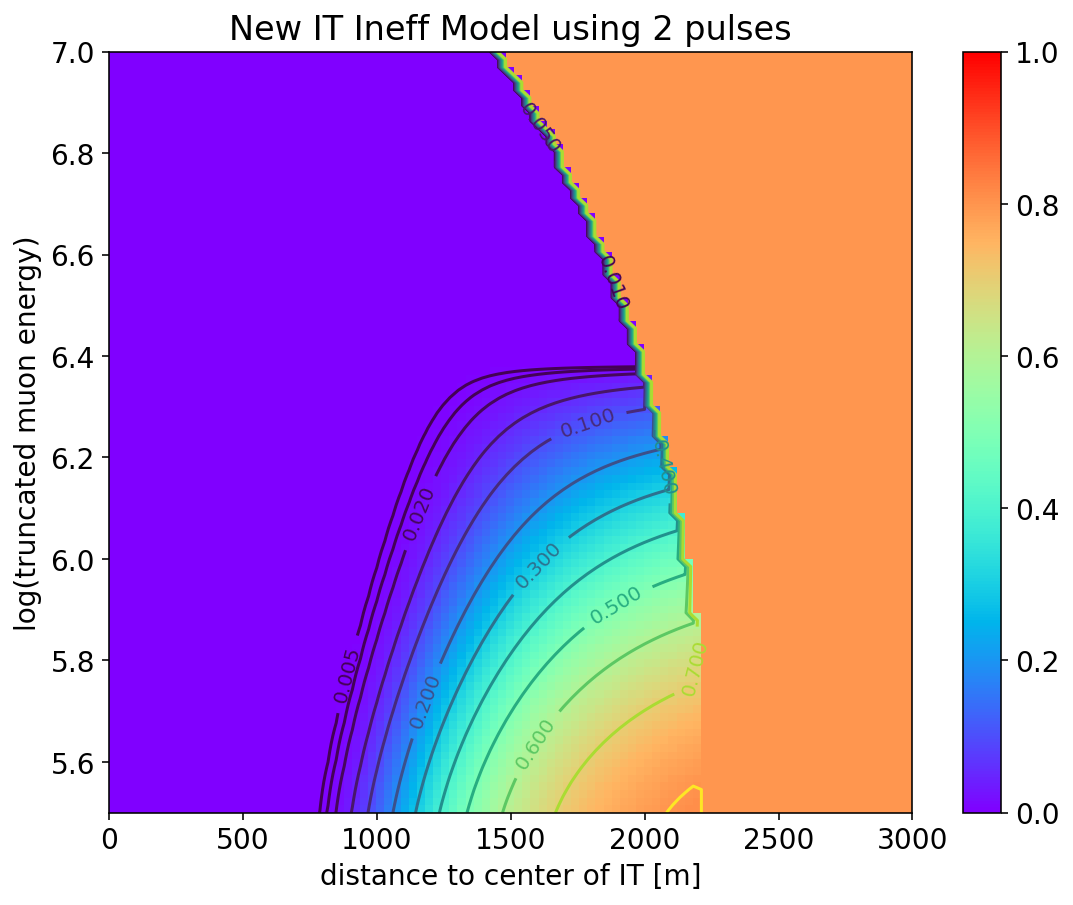

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

# read MC

In [5]:
# all nugen datasets:
nugen = {}

In [6]:
""" 11883 """

domeffs = ['0.89','0.99','1.09']
nfiles = [19995,20000,19988]
names = ['down','nominal','up']

for _domeff,_nfile,_name in zip(domeffs,nfiles,names):
    dic = {}
    nfile = _nfile
    
    with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5.'+_domeff+'_eff.h5','r') as f:

        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
        CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#         CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < 0.2   
        
        CUT_ineff = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])) < 0.01
        CUT_stoch = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
        
        CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_ineff & CUT_stoch
        
        dic['E_resolution'] = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:]))[CUT] 
        dic['chi2_red_new'] = f.root.Collection.cols.chi2_red_new[:][CUT]
        dic['zenith'] = f.root.SplineMPE.cols.zenith[:][CUT]
        dic['truncated'] = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        dic['NPE'] = f.root.QTot.cols.value[:][CUT]
        dic['coincidence'] = f.root.MCPrimary_coincident.cols.value[:][CUT]
        dic['prim_e'] = f.root.MCPrimary_new.cols.energy[:][CUT]
        dic['zenith_truth'] = f.root.MCPrimary_new.cols.zenith[:][CUT]

        dic['weight_conv'] = f.root.weight_honda2006[:][CUT] * lifetime/nfile  * 2
        dic['weight_prompt'] = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/nfile  * 2

        ### astrophysical ###
        energy = f.root.MCPrimary_new.cols.energy[:][CUT]
        OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
        NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
        dic['weight_astro'] = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(nfile * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

        dic['runid'] = f.root.I3EventHeader.cols.Run[:][CUT]
        dic['eventid'] = f.root.I3EventHeader.cols.Event[:][CUT]
    # convert to dataframe
    
    def ntuples():
        list_of_names = df.columns.values
        list_of_names_dict = {x:x for x in list_of_names}

        Varnames = namedtuple('Varnames', list_of_names) 
        return Varnames(**list_of_names_dict)    
    df = pd.DataFrame(dic)
    v = ntuples()

    nugen['domeff_'+_name+'_11883'] = df

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [7]:
""" 21047 """

variation = [
    "nugen_21047_p0=-1.0_p1=-0.2_domeff=1.00.h5",
    "nugen_21047_p0=-1.0_p1=0.0_domeff=1.00.h5",
    "nugen_21047_p0=-1.0_p1=0.2_domeff=1.00.h5",
    "nugen_21047_p0=-2.0_p1=-0.2_domeff=1.00.h5",
    "nugen_21047_p0=-2.0_p1=0.0_domeff=1.00.h5",
    "nugen_21047_p0=-2.0_p1=0.2_domeff=1.00.h5",
    "nugen_21047_p0=0.0_p1=-0.2_domeff=1.00.h5",
    "nugen_21047_p0=0.0_p1=0.0_domeff=0.90.h5",
    "nugen_21047_p0=0.0_p1=0.0_domeff=0.95.h5",
    "nugen_21047_p0=0.0_p1=0.0_domeff=1.00.h5",
    "nugen_21047_p0=0.0_p1=0.0_domeff=1.05.h5",
    "nugen_21047_p0=0.0_p1=0.0_domeff=1.10.h5",
    "nugen_21047_p0=0.0_p1=0.2_domeff=1.00.h5",
    "nugen_21047_p0=1.0_p1=-0.2_domeff=1.00.h5",
    "nugen_21047_p0=1.0_p1=0.0_domeff=1.00.h5",
    "nugen_21047_p0=1.0_p1=0.2_domeff=1.00.h5",
]

nfiles = [
         9903,
         9894,
         9889,
         9897,
         9874,
         9905,
         9885,
         9910,
         9887,
         9903,
         9896,
         9903,
         9895,
         9885,
         9899,
         9896,
         ]


names = [
    "p0 -1.0, p1 -0.2, domeff=1", #  
    "p0 -1.0, p1 0.0, domeff=1", #  
    "p0 -1.0, p1 0.2, domeff=1", #  
    "p0 -2.0, p1 -0.2, domeff=1", #  
    "p0 -2.0, p1 0.0, domeff=1", #  
    "p0 -2.0, p1 0.2, domeff=1", #  
    "p0 0.0, p1 -0.2, domeff=1", #  
    "p0 0.0, p1 0.0, domeff=0.90",
    "p0 0.0, p1 0.0, domeff=0.95",
    "p0 0.0, p1 0.0, domeff=1", #  
    "p0 0.0, p1 0.0, domeff=1.05",
    "p0 0.0, p1 0.0, domeff=1.10", 
    "p0 0.0, p1 0.2, domeff=1", #  
    "p0 1.0, p1 -0.2, domeff=1", #
    "p0 1.0, p1 0.0, domeff=1", # 
    "p0 1.0, p1 0.2, domeff=1", #
        ]

for _variation,_nfile,_name in zip(variation,nfiles,names):
    dic = {}
    nfile = _nfile
    
    with tables.open_file(data_dir+_variation,'r') as f:

        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
        CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#         CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < 0.2   
        
        CUT_ineff = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])) < 0.01
        CUT_stoch = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
        
        CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_ineff & CUT_stoch
        
        dic['E_resolution'] = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:]))[CUT] 
        dic['chi2_red_new'] = f.root.Collection.cols.chi2_red_new[:][CUT]
        dic['zenith'] = f.root.SplineMPE.cols.zenith[:][CUT]
        dic['truncated'] = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        dic['NPE'] = f.root.QTot.cols.value[:][CUT]
        dic['coincidence'] = f.root.MCPrimary_coincident.cols.value[:][CUT]
        dic['prim_e'] = f.root.MCPrimary_new.cols.energy[:][CUT]
        dic['zenith_truth'] = f.root.MCPrimary_new.cols.zenith[:][CUT]

        dic['weight_conv'] = f.root.weight_honda2006_h3a[:][CUT] * lifetime/nfile  * 2
        dic['weight_prompt'] = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/nfile  * 2

        ### astrophysical ###
        energy = f.root.MCPrimary_new.cols.energy[:][CUT]
        OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
        NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
        dic['weight_astro'] = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(nfile * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

        dic['runid'] = f.root.I3EventHeader.cols.Run[:][CUT]
        dic['eventid'] = f.root.I3EventHeader.cols.Event[:][CUT]
    # convert to dataframe
    
    def ntuples():
        list_of_names = df.columns.values
        list_of_names_dict = {x:x for x in list_of_names}

        Varnames = namedtuple('Varnames', list_of_names) 
        return Varnames(**list_of_names_dict)    
    df = pd.DataFrame(dic)
    v = ntuples()

    nugen['holeice_'+_name] = df

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


# study 1d distributions

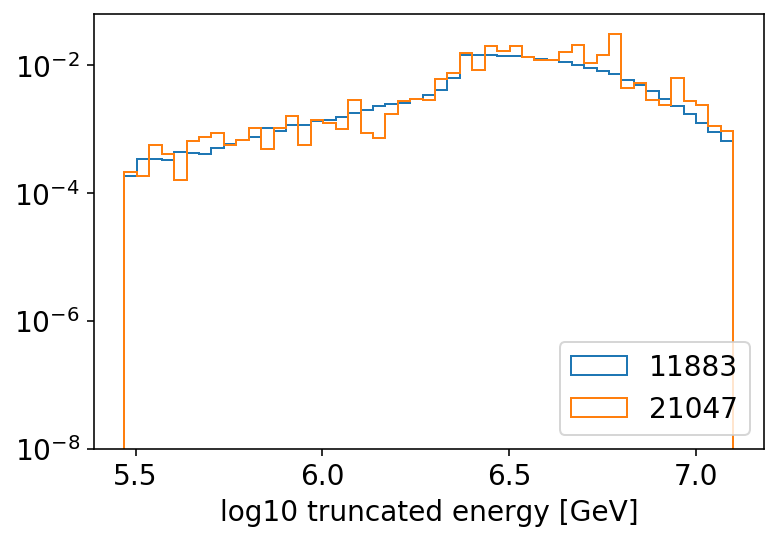

In [8]:
plt.hist(np.log10(nugen["domeff_nominal_11883"]['truncated']),bins=np.linspace(5.47,7.1,50),log=True,weights=nugen["domeff_nominal_11883"]['weight_astro'],label='11883',histtype='step',bottom=1e-8)
sel = np.log10(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['prim_e']) < 7
h11,b11,_=plt.hist(np.log10(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['truncated'][sel]),bins=np.linspace(5.47,7.1,50),log=True,weights=nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['weight_astro'][sel],label='21047',histtype='step',bottom=1e-8)
plt.xlabel('log10 truncated energy [GeV]')
plt.legend(loc='lower right')
plt.show()

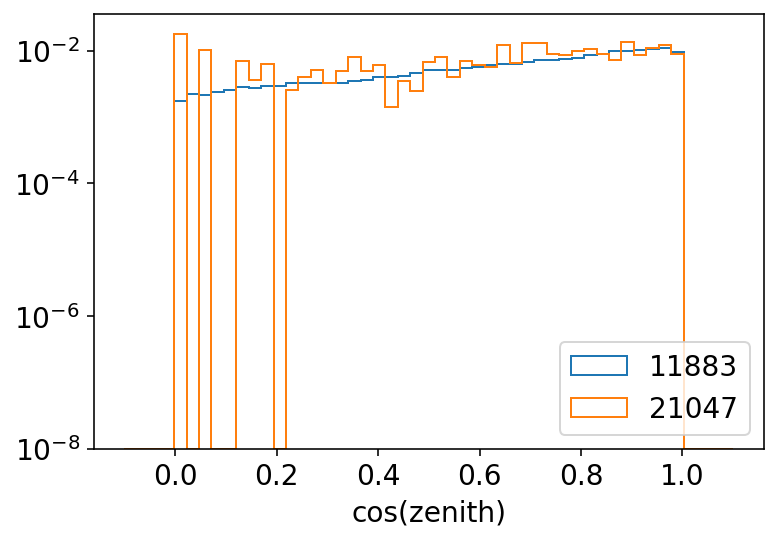

In [9]:
plt.hist(np.cos(nugen["domeff_nominal_11883"]['zenith']),bins=np.linspace(-0.1,1.1,50),log=True,weights=nugen["domeff_nominal_11883"]['weight_astro'],label='11883',histtype='step',bottom=1e-8)
sel = np.log10(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['prim_e']) < 7
h11,b11,_=plt.hist(np.cos(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['zenith'][sel]),bins=np.linspace(-0.1,1.1,50),log=True,weights=nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['weight_astro'][sel],label='21047',histtype='step',bottom=1e-8)
plt.xlabel('cos(zenith)')
plt.legend(loc='lower right')
plt.show()

In [10]:
def comparison(vars,weight,varname,bins,xlabel,title):
    
    plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
    bins = bins
    Ecut = 1e7
    cmap = matplotlib.cm.get_cmap('rainbow')
    hs = []
    bs = []
    cmap_count, cmap_diff = 0, 1/len(vars)
    
    for var in vars:
        cut = nugen[var]['prim_e'] < Ecut
        p0 = var.split('p0 ')[1].split(',')[0]
        p1 = var.split('p1 ')[1].split(',')[0]
        if varname == 'truncated':
            h_,b_,_=plt.hist(np.log10(nugen[var][varname][cut]),bins=bins,log=True,weights=nugen[var][weight][cut],label='p0={}, p1={}'.format(p0,p1),histtype='step',color=cmap(cmap_count+cmap_diff),bottom=1e-8)
        elif varname == 'zenith':
            h_,b_,_=plt.hist(np.cos(nugen[var][varname][cut]),bins=bins,log=True,weights=nugen[var][weight][cut],label='p0={}, p1={}'.format(p0,p1),histtype='step',color=cmap(cmap_count+cmap_diff),bottom=1e-8)
        hs.append(h_)
        bs.append(b_)
        cmap_count += cmap_diff

    cut_nominal = np.log10(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['prim_e']) < 7
    if varname == 'truncated':
        h_nominal,b_nominal,_=plt.hist(np.log10(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['truncated'][cut_nominal]),bins=bins,log=True,weights=nugen["holeice_p0 0.0, p1 0.0, domeff=1"][weight][cut_nominal],label='nominal',histtype='step',color='black',bottom=1e-8)
    elif varname == 'zenith':
        h_nominal,b_nominal,_=plt.hist(np.cos(nugen["holeice_p0 0.0, p1 0.0, domeff=1"]['zenith'][cut_nominal]),bins=bins,log=True,weights=nugen["holeice_p0 0.0, p1 0.0, domeff=1"][weight][cut_nominal],label='nominal',histtype='step',color='black',bottom=1e-8)

    
    plt.ylabel('Events in 365 days')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(np.min(h_nominal[h_nominal>0])/2,)
    plt.legend(prop={'size': 11},loc='upper left')
    plt.title(title)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    
    
    ax2 = plt.subplot(gs[1])
    
    b = (b_nominal[1:] + b_nominal[:-1])/2
    
    cmap_count, cmap_diff = 0, 1/len(vars)
    for h in hs:
        plt.plot(b,h/h_nominal, '.-',color=cmap(cmap_count+cmap_diff))
        cmap_count += cmap_diff
    
    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')

    plt.xlabel(xlabel)
    plt.ylabel('ratio to nominal')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(0.5,1.5)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))


In [11]:
#     "nugen_21047_p0=-1.0_p1=-0.2_domeff=1.00.h5",
#     "nugen_21047_p0=-1.0_p1=0.0_domeff=1.00.h5",
#     "nugen_21047_p0=-1.0_p1=0.2_domeff=1.00.h5",

#     "nugen_21047_p0=-2.0_p1=-0.2_domeff=1.00.h5",
#     "nugen_21047_p0=-2.0_p1=0.0_domeff=1.00.h5",
#     "nugen_21047_p0=-2.0_p1=0.2_domeff=1.00.h5",

#     "nugen_21047_p0=0.0_p1=-0.2_domeff=1.00.h5",
#     "nugen_21047_p0=0.0_p1=0.0_domeff=1.00.h5", # nominal
#     "nugen_21047_p0=0.0_p1=0.2_domeff=1.00.h5",

#     "nugen_21047_p0=1.0_p1=-0.2_domeff=1.00.h5",
#     "nugen_21047_p0=1.0_p1=0.0_domeff=1.00.h5",
#     "nugen_21047_p0=1.0_p1=0.2_domeff=1.00.h5",

In [12]:
""" zenith distributions """

' zenith distributions '

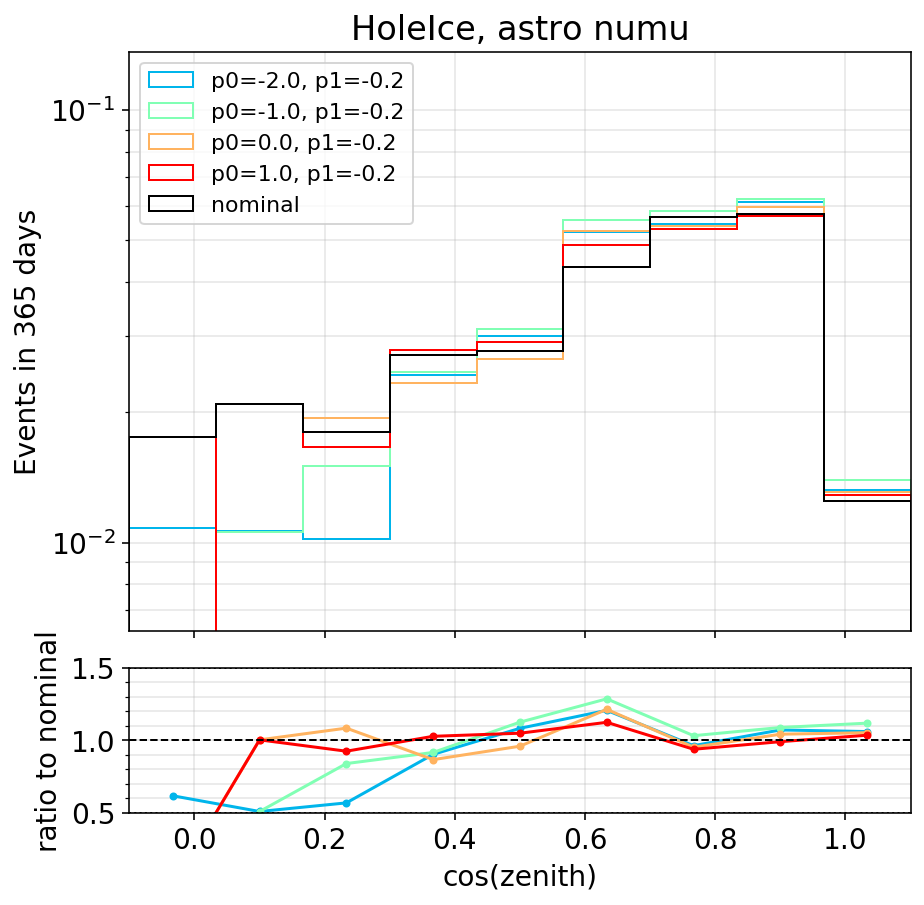

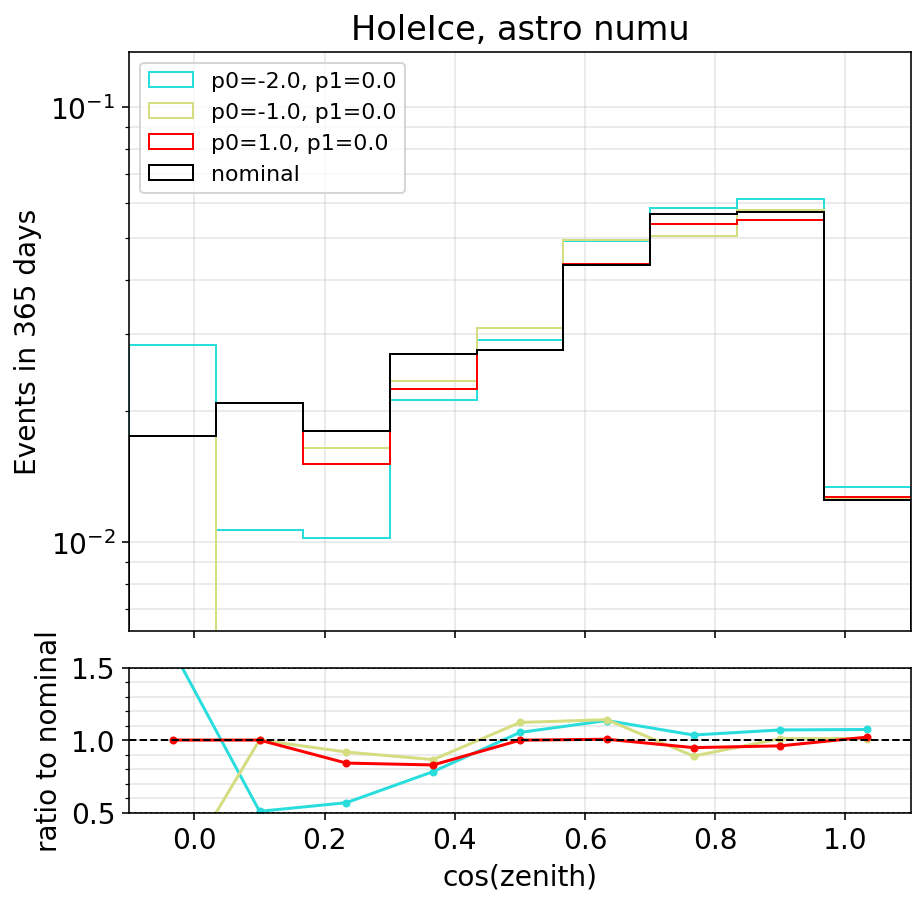

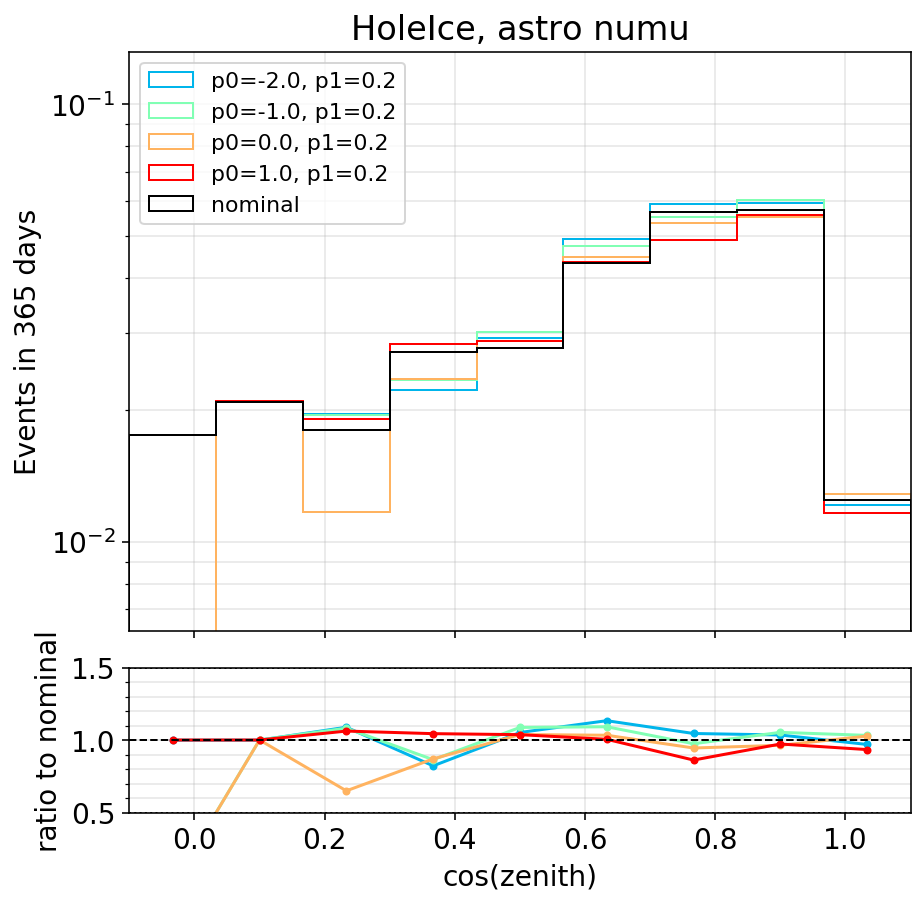

In [13]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

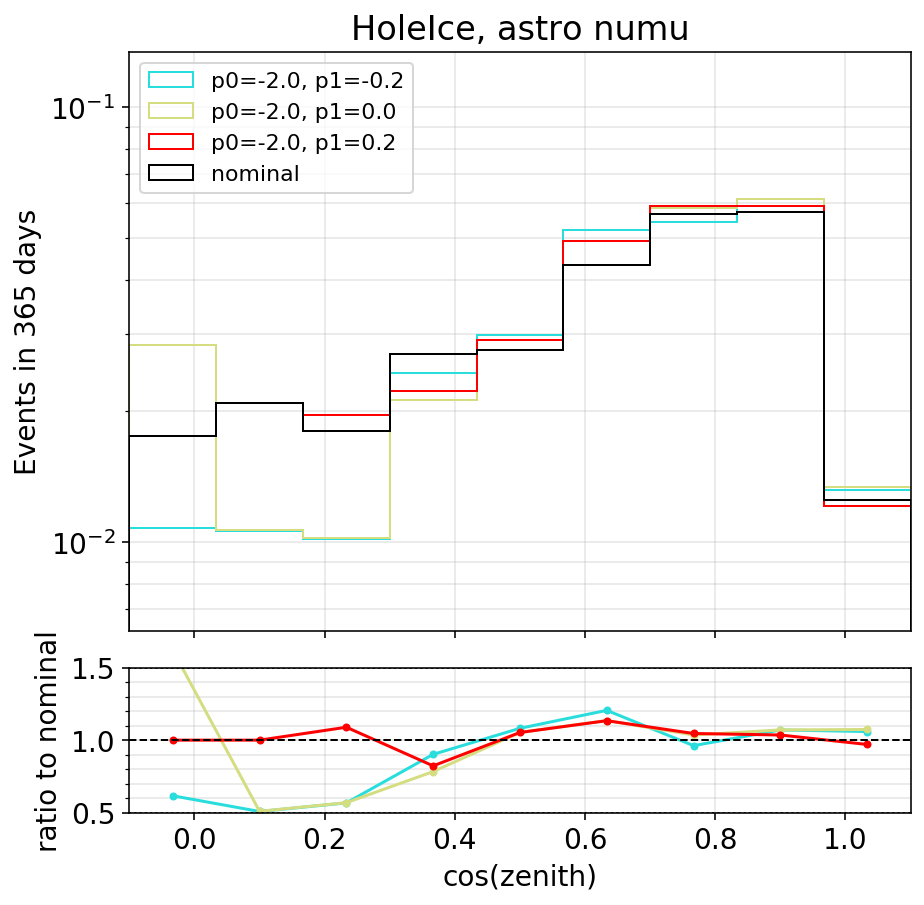

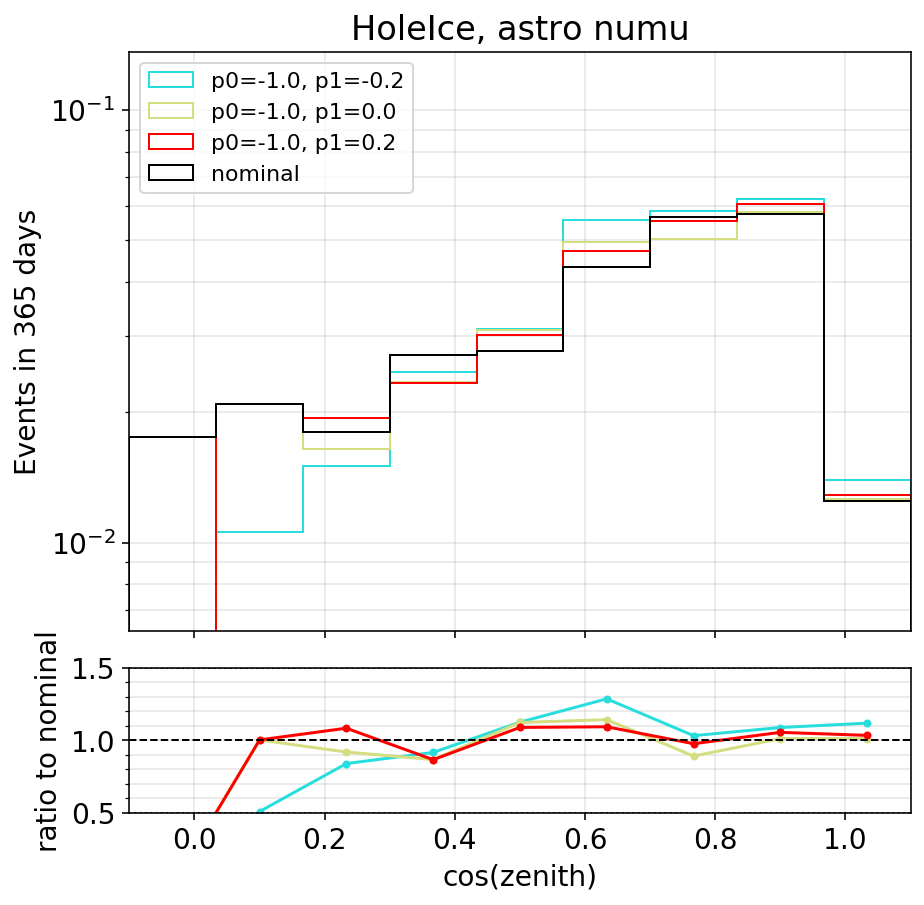

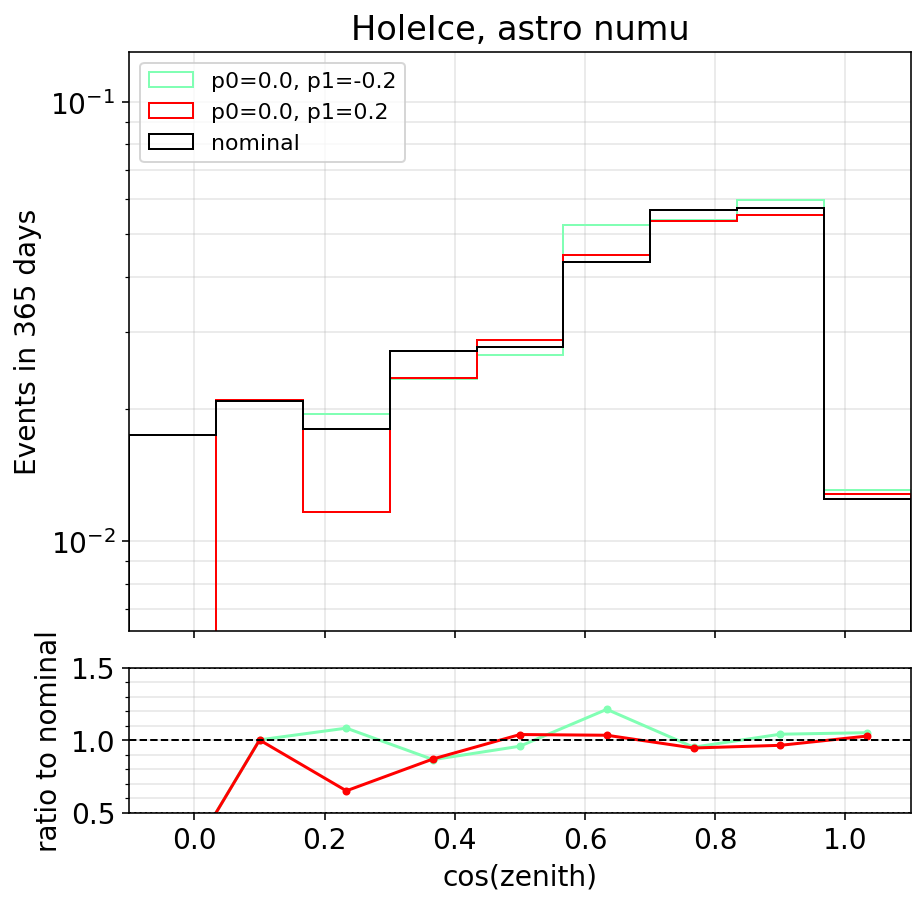

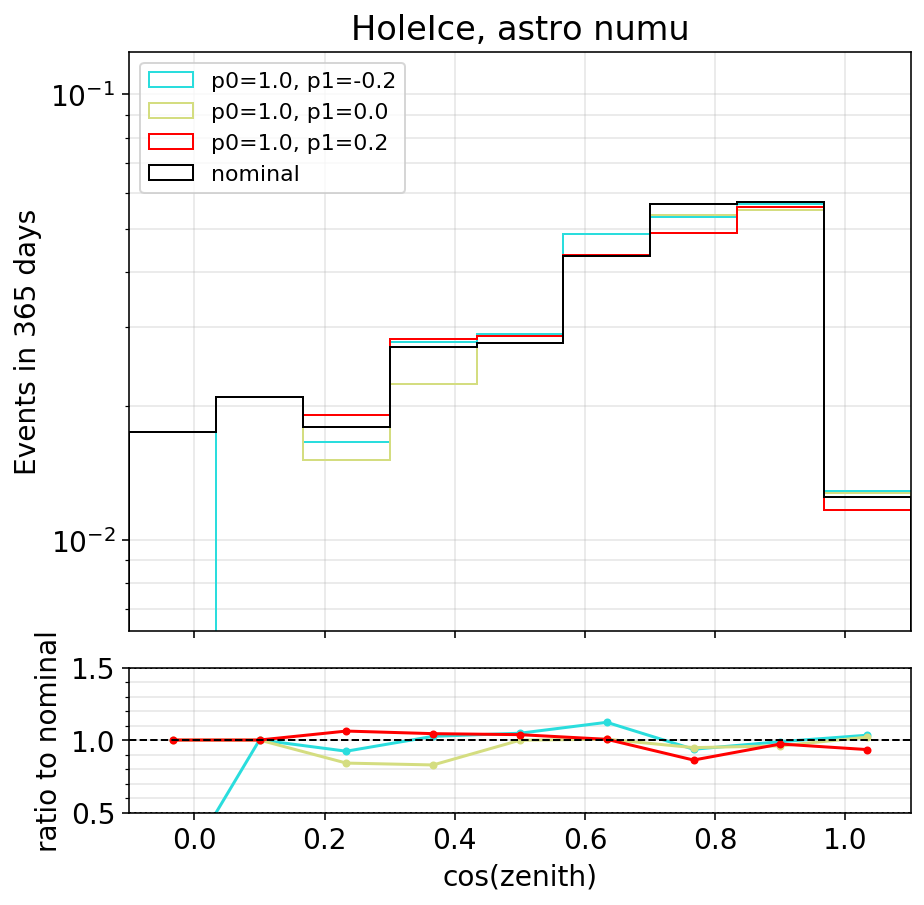

In [14]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(-0.1,1.1,10),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

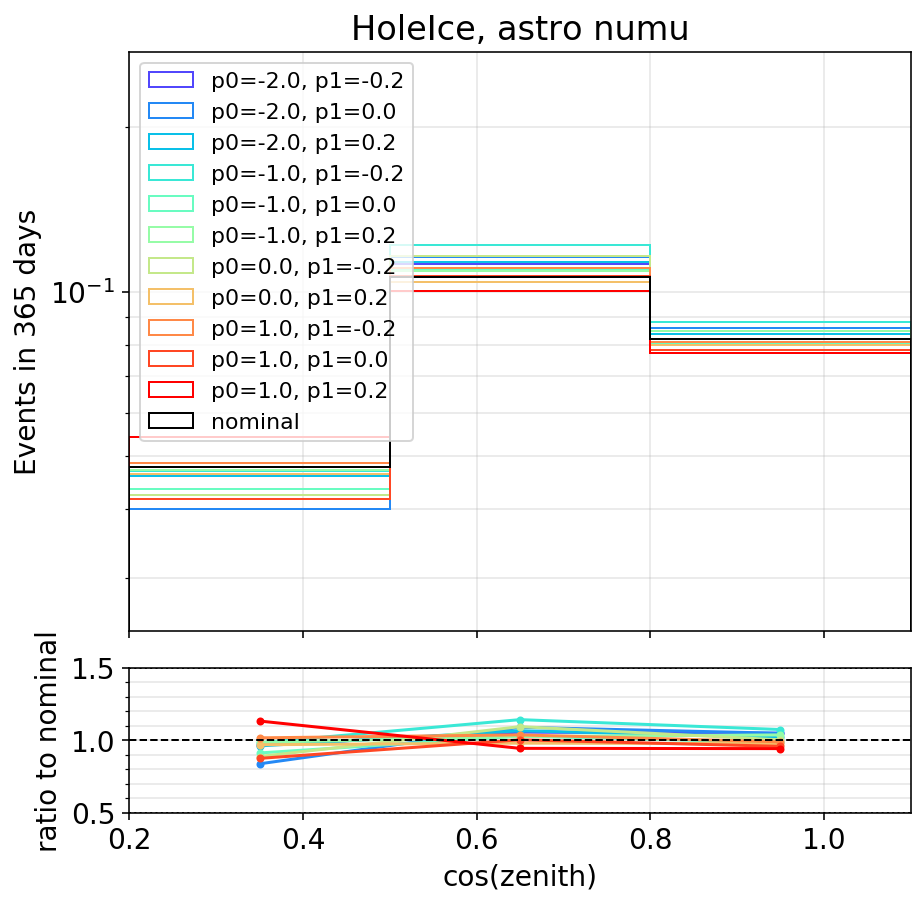

In [15]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'zenith',
            np.linspace(0.2,1.1,4),
            'cos(zenith)',
            'HoleIce, astro numu'
          )

In [16]:
""" energy distributions """

' energy distributions '

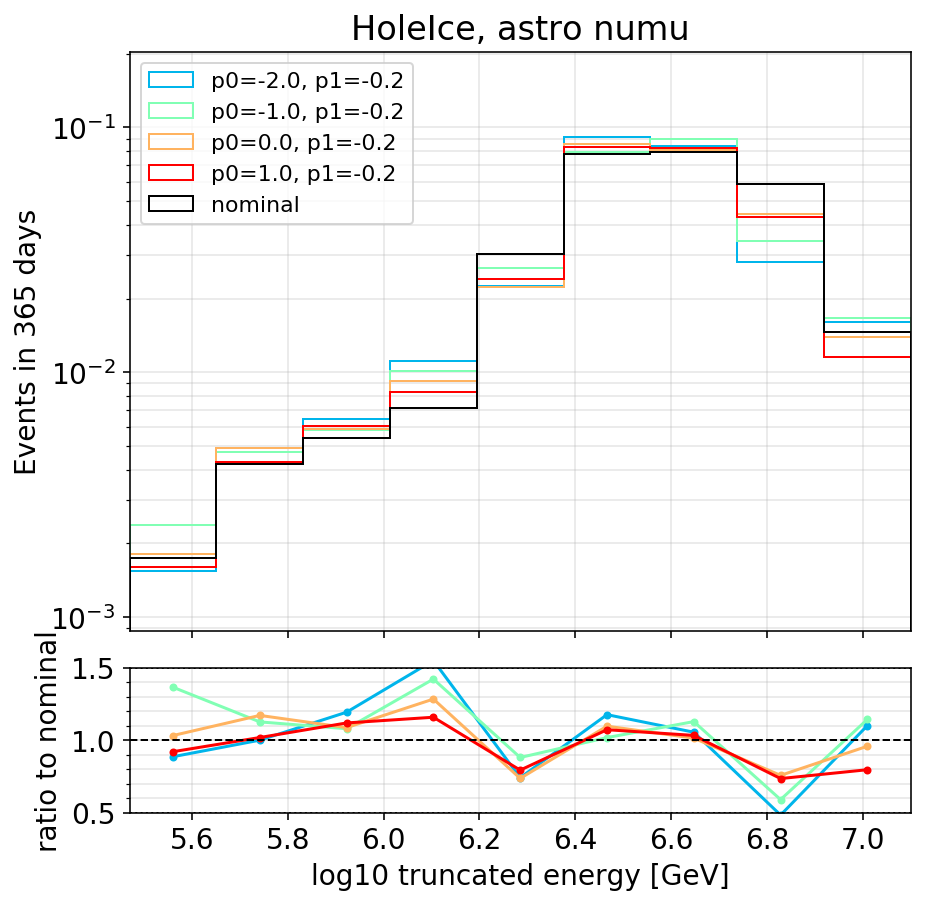

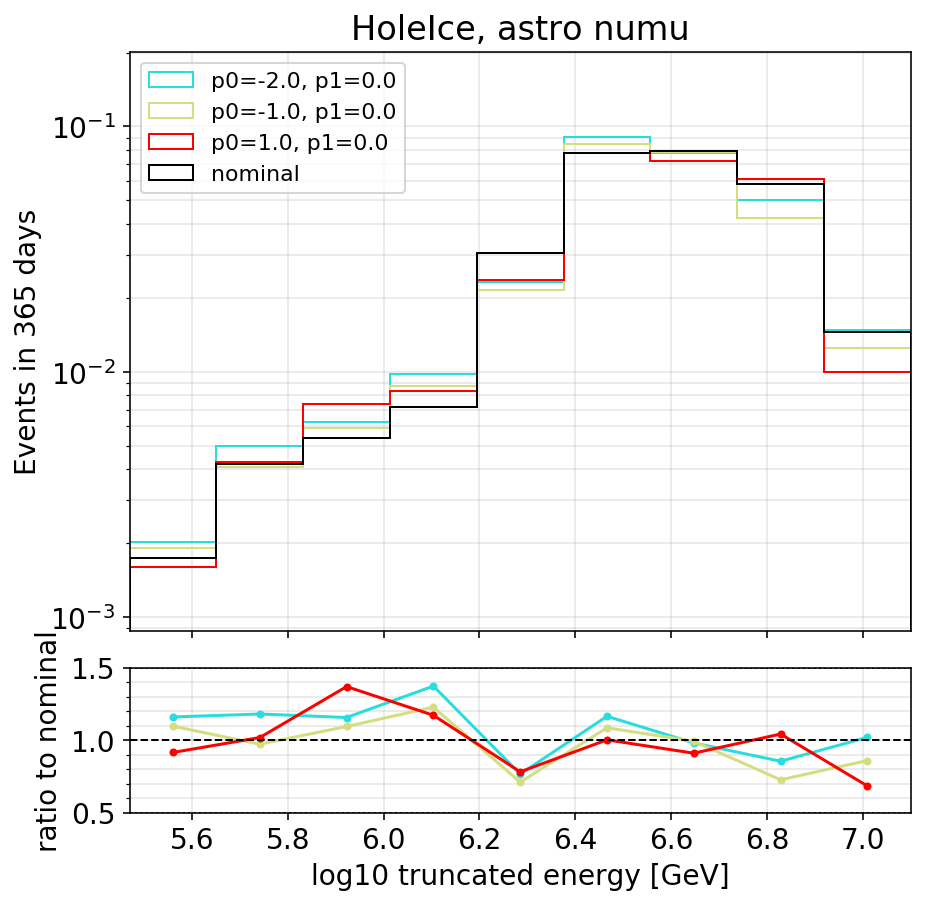

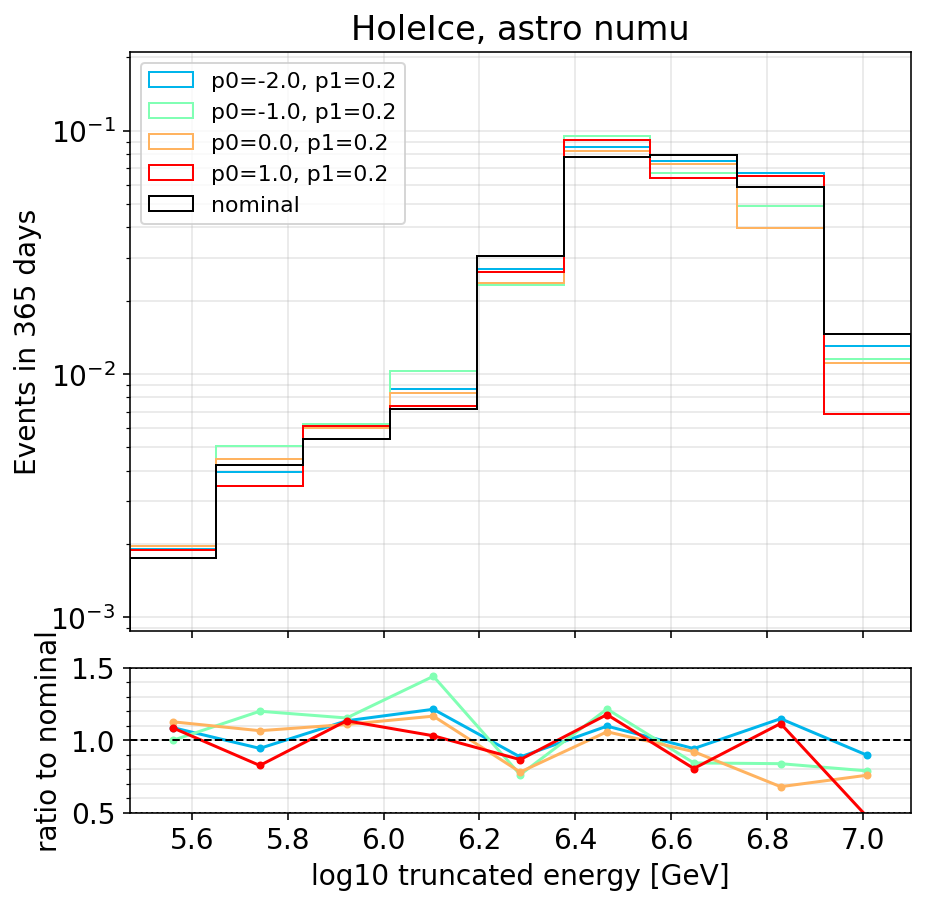

In [17]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

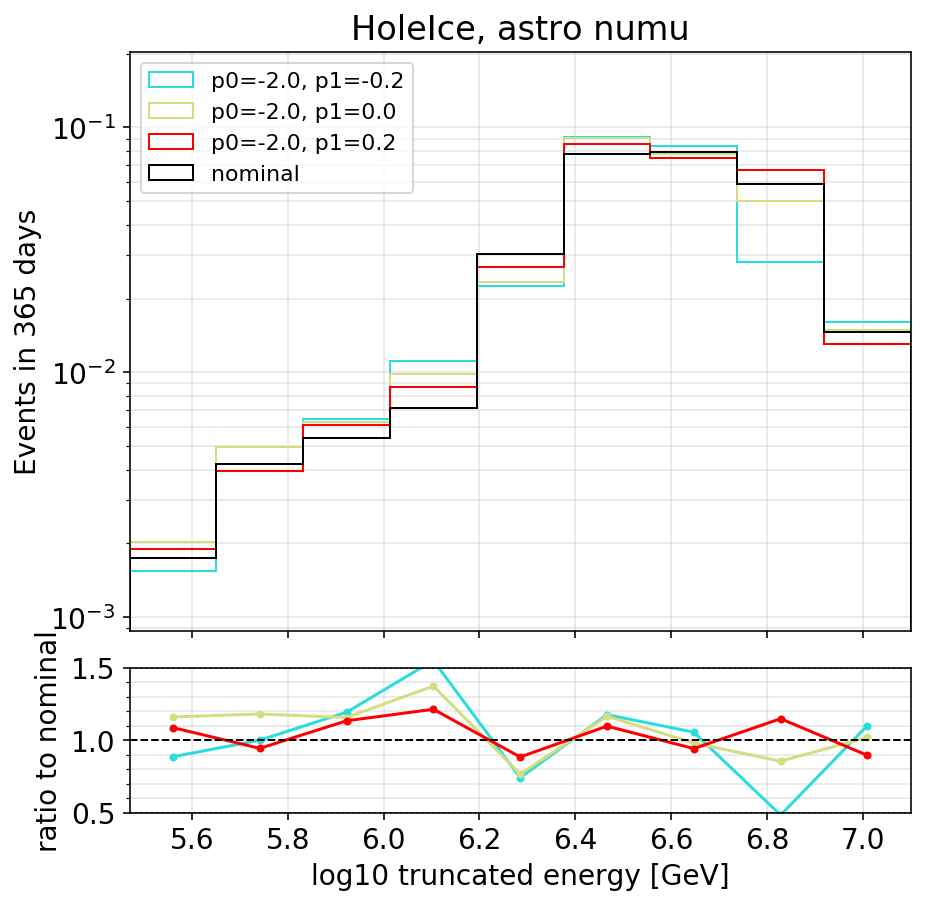

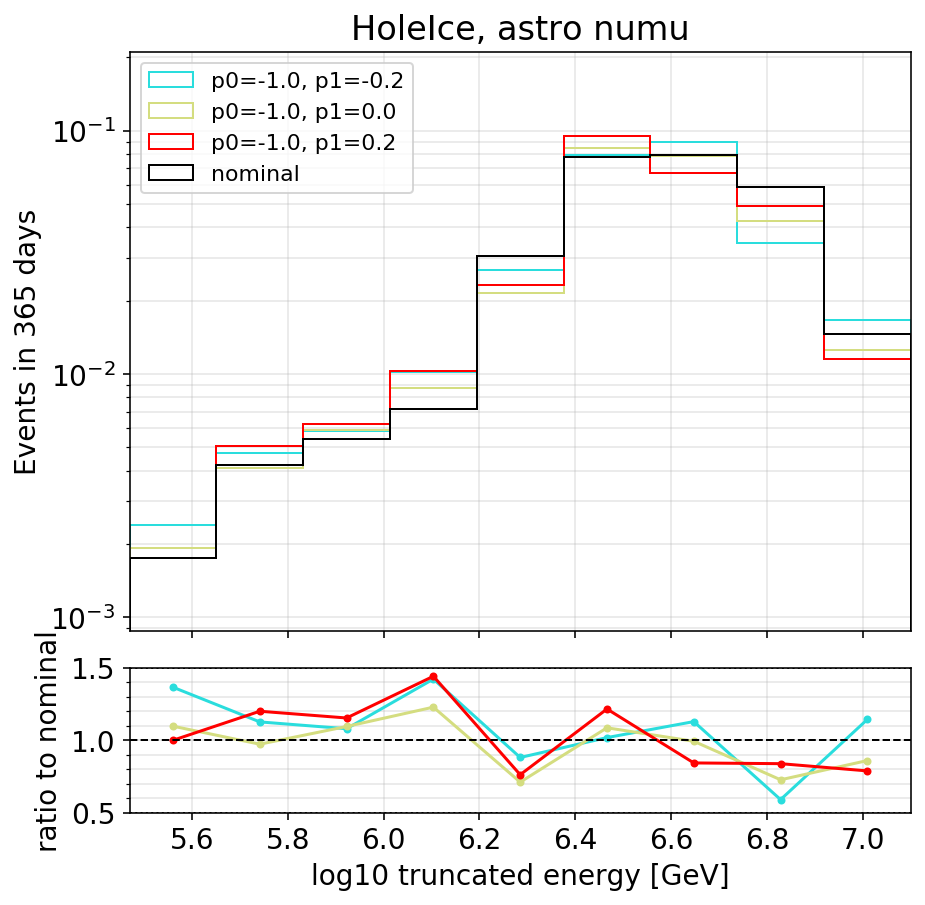

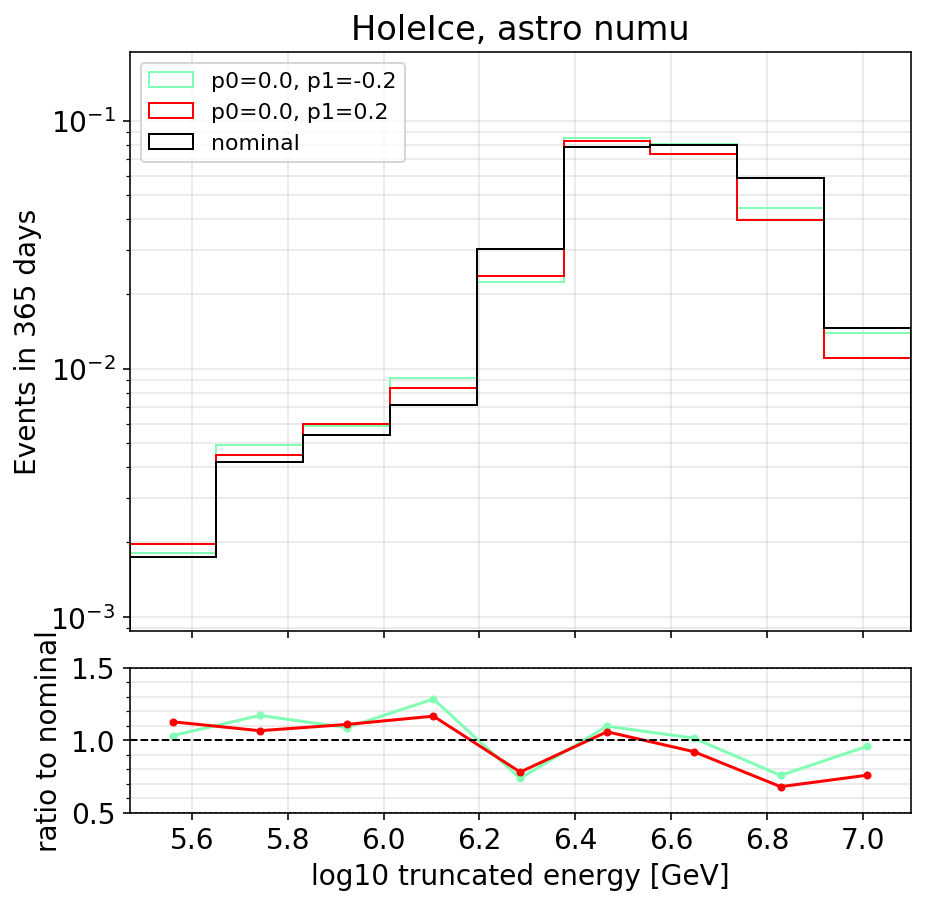

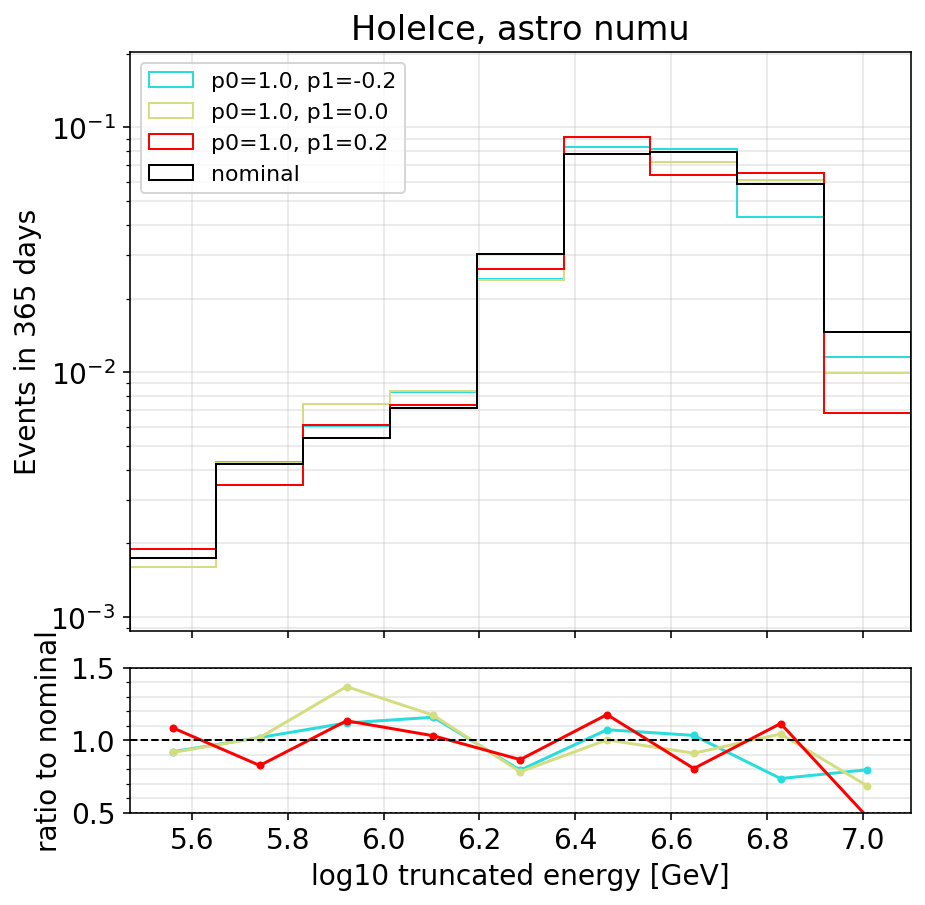

In [18]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

comparison([
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,10),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

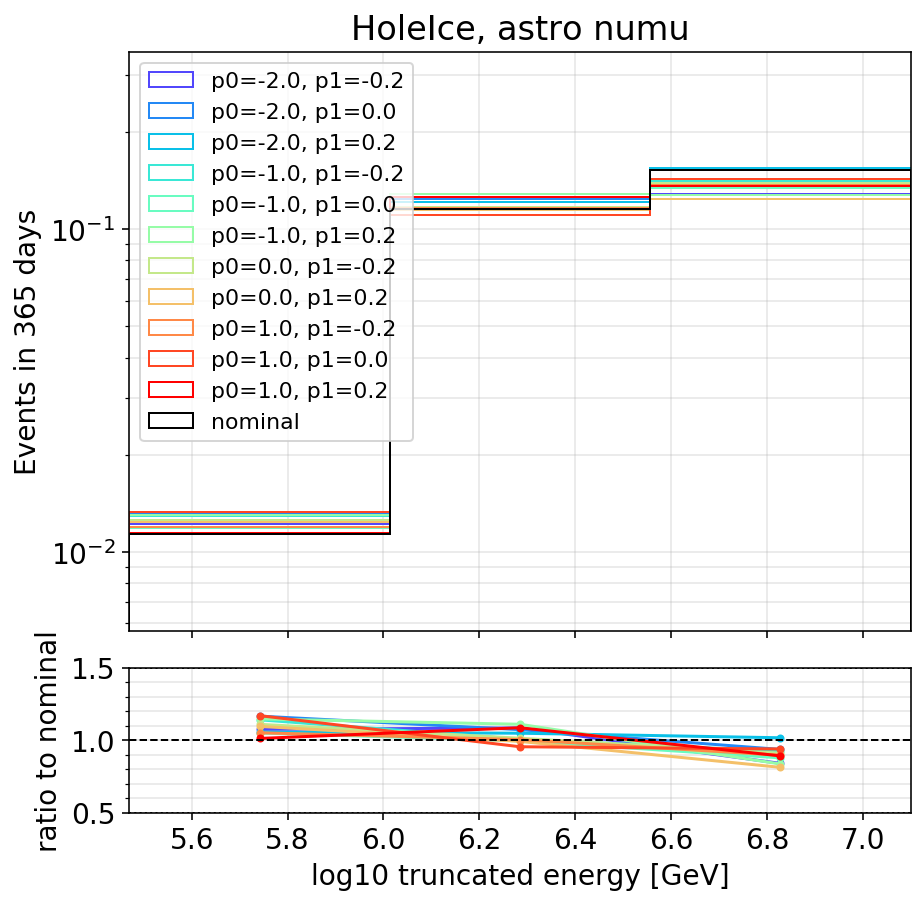

In [19]:
comparison([
            'holeice_p0 -2.0, p1 -0.2, domeff=1',
            'holeice_p0 -2.0, p1 0.0, domeff=1',
            'holeice_p0 -2.0, p1 0.2, domeff=1',
            'holeice_p0 -1.0, p1 -0.2, domeff=1',
            'holeice_p0 -1.0, p1 0.0, domeff=1',
            'holeice_p0 -1.0, p1 0.2, domeff=1',
            'holeice_p0 0.0, p1 -0.2, domeff=1',
            'holeice_p0 0.0, p1 0.2, domeff=1',
            'holeice_p0 1.0, p1 -0.2, domeff=1',
            'holeice_p0 1.0, p1 0.0, domeff=1',
            'holeice_p0 1.0, p1 0.2, domeff=1',
            ],
            'weight_astro',
            'truncated',
            np.linspace(5.47,7.1,4),
            'log10 truncated energy [GeV]',
            'HoleIce, astro numu'
          )

# save to event weights 

In [25]:
# with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/splines/myown_syst/holeice_spline.pkl', 'wb') as output:
#     pickle.dump(interp_energy, output)
# np.save('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/splines/myown_syst/holeice_spline_best_norm.npy', [best_norm])

NameError: name 'best_norm' is not defined

In [20]:
class holeice: # an overall scaling independent of E and zenith.
    def __init__(self, norm):
        self.norm = norm
        
    def interp(self, E):
        scale = self.norm * E # ??????
        return scale

In [21]:
tosave = holeice(1)

In [24]:
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/splines/myown_syst/holeice_scaling.pkl', 'wb') as output:
    pickle.dump(tosave, output)#, pickle.HIGHEST_PROTOCOL)

# debug

In [23]:
sns.jointplot(np.cos(nugen['bulkice_nugen_21047 p0 0.0 p1 0.0 domeff=1.00.h5_11883']['zenith']),np.log10(nugen['bulkice_nugen_21047 p0 0.0 p1 0.0 domeff=1.00.h5_11883']['truncated']),kind='hex')
plt.colorbar()
plt.show()

KeyError: 'bulkice_nugen_21047 p0 0.0 p1 0.0 domeff=1.00.h5_11883'

In [ ]:
sns.jointplot(np.cos(nugen['domeff_nominal_11883']['zenith']),np.log10(nugen['domeff_nominal_11883']['truncated']),kind='hex')
plt.colorbar()
plt.show()